# Model Project: The Agents Labour Supply Decision


In present project we seek to model the supply of labour by studying a two-good static problem, where agents value leisure and consumption. As an extension for the base model we impose a progressive tax system, which creates kinks in the budget constraint. We then show, how this may create bunching around tax bracket cut-offs.

The basic problem of the agents is:


$$\begin{aligned}  \max_{c,l}\ \ &u(c,l) \quad s.t. \ \ R_0 = wl + c  \quad c,l\geq0\\
 &\dfrac{\partial u}{\partial a}= u_a>0 \quad  \wedge \quad \dfrac{\partial^2 u}{\partial a^2}=u_{aa}<0,  \qquad a=c,l \\
 &R_0=W_0(T,w) + A_0 = w T + A_0
 \end{aligned} $$
 

Where $R_0$ is the income potential of the agent, $c$ the consumption which is a numeraire, $l$ is the amount of leisure consumed with the associated oppurtunity cost being the wage rate, $w$. We assume marginal utility of consumption and leisure are positive but decreasing. Further we for now assume the income potential is the sum of wage earning potential, $W_0$, which is the renumeration for working the entirety of the time endowment ($T$ units), plus non-labour income, $A_0$. Assuming constant wage $W_0=w\times T$. <br> The problem is framed such that the agent at default suplies all his time as labour, giving her/him an income of $R_0$. The agent now has to decide how much leisure she/he will 'buy back', considering the consumption that is implied.

The Langrangian for the problem is:
$$ \mathcal{L}(c,l; \lambda)= u(c,l)\ + \ \lambda( R_0 - wl - c) $$ 
For which the first order conditions with regards to $c$ and $l$ implies an optimum at $\dfrac{u_l}{u_c}=w$ as the constraint is binding.

## Numerical optimization

We will solve this problem using a numerical optimizer, which will allow for easy handling of extensions to this basic model. 

Dependencies:

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy.optimize import Bounds
import scipy.integrate as integrate
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

First we code up two utility functions, a CES and a Cobb-Douglas, but any utility function that observes the above restrictions can be implemented.

In [2]:
# Cobb-Douglas:
def  _cobbdouglas(c,l, alpha):
    """ Cobb douglas utility function for 2 goods.
    
    INPUT:
    
    Parameters
    alpha : relative preference for consumption to leisure
    
    Consumption bundle
    c: consumption of goods
    l: leisure

    OUTPUT:
    u: utility (negative)"""
    u= (c**alpha)*l**(1-alpha)
    return -u
def  cobbdouglas(x,par):
    return _cobbdouglas(c=x[0],l=x[1], alpha=par)

# CES utility function:
def _CES(c,l, a,r):
    """ CES utility function for 2 goods.
    INPUT:
    
    parameters
    r: 1/(1-r) is the elasticity of substitution, r<=1.
    a: relative preference for consumption (a=1 if a unit of consumption gives the same utility as a unit lesiure), 0<=a<=1.
    
    consumption bundle
    c: consumption on goods (dollars spent)
    l: leisure (hrs pr. week)

    OUTPUT:
    u: utility (neg) """
    u=(a*c**r + (1-a)*l**r)**(1/r)
    return -u
def CES(x, par):
    """ Takes two tuples as argument:
    ARGS
    x 2-tuple:
        x0= consumption
        x1= leisure
    par (2-tuple):
        par[0]=a
        par[1]=r

    OUTPUT
    utility from consumption
    """
    return _CES(c=x[0],l=x[1], a=par[0],r=par[1]) 

We now have to define the constraints. Three moving parts are specified for the budget constraint (BC):<br>
1) Wage function: returning the after tax wagerate for for a given level of leisure consumption.<br>
2) Leisure expenditure function: returns the expenditure incurred from buying 'l' units of leisure. <br>
3) The budget function: calculates the slack in budget given choices of leisure and consumption (the actual constraint). <br>

In [3]:
# 1) Wage function: returning the after tax wagerate for for a given level of leisure consumption (the more leisure the lower taxrate = higher wagerate).<br>
def wage_flat(l):
    """ Marg. wage function with no taxation is (constant):
        
        PARAMETERS:
        w: constant wage
        ARGS:
        l: leisure 
        
        OUTPUT:
        The marginal after tax wage rate
    """
    return w
#2) Leisure expenditure function:
def leiexp(l,wage):
    """ Calculates the expenditure from buying l units of leisure given a wage function as the definite integral
    from 0 to l of the wage function.
    ARGS:
    l: leisure consumed (int)
    Wage: Marginal wage-function (incoperating tax system) (function)
    
    OUTPUT:
    leiexp: expenditure on leisure (int)
    """
    return sp.integrate.quad(wage,0,l)[0]

#3) Budget constraint
def budget(x, wage, maxlabinc, leiexp):
    """The budget functin calculates the slack for consumption plan:
    ARGS
    x (2-tuple)
         x[0]: consumption of good
         x[1]: consumption of leisure
    wage(l)  : marg. wage/price of leisure (function)
    maxlabinc: Labour income from working T units of time (int)
    leiexp   : leisure expenditure (function)
    
    OUTPUT:
    slack: 'Leftover' given consumption plan x.
    """
    c=x[0]
    l=x[1]
    R0= maxlabinc + A
    slack= R0 - leiexp(l, wage) - c
    return  slack
def budget_func(wage,maxlabinc,leiexp):
    """ Produces the budget constraint to input in maximizer.  It is a equality contraint -> slack shall be zero in optimum
    as marg. utility of both goods is stricty positive.
    
    ARGS:
    Wage: marg. wage function
    maxlabinc: integral of wage fucntion from 0 to T
    leiexp   : leisure expenditure (function)
    
    OUTPUT:
    Budget Contraint: Dict. specifying the constraint to be used in scipy.optimize.minimize
    """
    return {'type':'eq', 'fun':budget, 'args': [wage, maxlabinc,leiexp]} 

Note: 1) That we define the wage as a function this allows us to extend the model, 2) Expenditure on leisure is calculated as the definite integral of the wage function from 0 to l, this allows for altering the wage function
3) we have yet to define the bounds on consumption/leisure, as these depend on T, we will define them within when parameters are chosen.



### Example: Cobb Douglas utility with constant wage
For a Cobb-Douglas utility functions, $u(c,l)= c^\alpha l^{1-\alpha}$, the solution Marshallian demand functions are:
$$c^*= w l \left(\dfrac{\alpha}{1-\alpha}\right)=R_0 \alpha \qquad l^*=\dfrac{R_0 (1-\alpha)}{w}$$
These can be obtained by isolating factor demand for one good from the optimum condition and inserting this into the budget constraint.
However to initially test our program, we will compare the analytical solution for a particular set of parameters to the optimizer:

In [4]:
# Budget related parameters
T=10 # 10 units of time endowed
w=10 # flat hourly wage of 10
A=20 # 20 income from non labour sources
maxlabinc=leiexp(T,wage_flat) #Calculates 
# Utility related parameters
alpha=0.5 # Assuming

# Optimizer setup:
bounds= Bounds((0,0), (np.inf, T))

Given these parameters, we find $R_0=10\times10 + 20$, and analytical solution for optimal consumption choices are _$c^*=120\times0.5=60$ and $l^*=\dfrac{120\times0.5}{10}=6$_. <br>
The numerical optmization is performed by the 'SLSQP' algorithm for constrained optimization included in sci.py:

In [5]:
guess=(5, 70) 
result = optimize.minimize(cobbdouglas,guess,args=alpha,
                             method='SLSQP',
                             constraints=[budget_func(wage_flat,maxlabinc,leiexp)],
                             options={'disp':True}, bounds=bounds)
 

print('\nx = ',result.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -18.97366596100426
            Iterations: 8
            Function evaluations: 32
            Gradient evaluations: 8

x =  [59.99995223  6.00000478]


Deviations in the analytical and numerical solutions can be chalked up to numerical precision.

## Progressive tax system

First we code up a wage function, which accounts for changes in marginal taxation:

In [6]:
#1) Wage function 
def wage_prog(l):
    """ Wage function for a progressive tax system with allowing for two specified kinks
        2 kinks (3 tax brackets).
        
        PARAMETERS:
        cut1, cut2: cutoff for tax brackets defined by consumption of
                    leisure.
        w0,w1,w2: wage rates in the respective tax brackets.
        
        ARGS:
        demand typle, x: x[0] cons, x[1] lesiure consumption
        
        OUTPUT:
        w0,w1,w2: the appropriate marginal after tax wage rate
    """
    if l < l_top:
        return w*(1-toptax)
    elif l_top<= l and l < l_bot:
        return w*(1-bottax)
    else:
        return w

#2b) leisure expenditure progressive function (analytical):
def leiexp_prog(l,wage): 
    """ Returns the expenditure associated with buying 'l' units of leisure for the progressive tax system using the analytical 
    integral of the marginal wage function. 
    INPUTS
    l   : amount of leisure consumed
    wage: marg. wage function  NOT USED when the leisure expenditure is calculated analytically, but included such that 
          the program generalizes easily to other wage functions.
    OUTPUT
    leiexp : expenditure associated with buying leisure on the progressive tax system.
    """
    if l < l_top:
        return w*l_bot+w*(1-bottax)*(l_bot-l_top)+w*(1-toptax)*(l_top-l)
    elif l_top<= l and l < l_bot:
        return  w*l_bot+w*(1-bottax)*(l_bot-l)
    else:
        return w*l


The tax system has 3 brackets: no tax, bottom tax and top tax. Due to the way we frame the problem, this amounts to the marginal cost of leisure increasing in the demand for leisure. This is to say, the more leisure an agent consumes the lower his marginal tax is (because earnings are low), thus the marginal price (after tax wage rate) of leisure increases the more leisure is consumed. This can be expressed as:
$$w(l) = \begin{cases} & w \quad &\text{for } l> l_{bottom} \\
                       & w \times (1-t_{bottom}) \quad &\text{for } l_{top} <l < l_{bottom}  \\
                       & w \times (1-t_{top}) \quad &\text{for } l < l_{top}  \end{cases}, \quad l_{bottom}> l_{top} \ \wedge \ t_{bottom}<t_{top}$$

We implement a tax system, where the first 1/3 of the time endowment supplied as labour is not taxed, the next 1/3 of time endowment is taxed in the bottom tax bracket, and additional labour is taxed in the top tax bracket. The marginal tax in the bottom tax bracket is set to 30% and in the top tax bracket to 60%. When framed as buying leisure this implies:

$$w(l) = \begin{cases} & w \quad &\text{for } l> T\times \dfrac{2}{3} \\
                       & w \times (1-0.3) \quad &\text{for } T \times \dfrac{2}{3} >l > T\times \dfrac{1}{3}  \\
                       & w \times (1-0.6) \quad &\text{for } T\times \dfrac{1}{3}>l  \end{cases}$$

In the example for constant wage we defined the leisure expenditure as the definite integral of the wage function, which was approximated numerically (SciPy). For this example will instead derive the integral analytically to ease computation down the road:
$$ leisure\_expenditure = \begin{cases}  \end{cases}$$

Now we simulate agents with differing draws of $\alpha$, where $\alpha_i \sim$ uniform$[0,1]$, and use numerical optmization to find their optimal consumption of leisure and goods:

In [11]:
# Set wage function 
l_top= 1/3*T # Work more than 2/3 of your time and pay top tax
l_bot= 2/3*T # work more than 1/3 of your time and pay bottom tax
toptax= 0.6 # setting top tax
bottax= 0.3 # setting bottom tax 
maxlabinc_prog=leiexp_prog(T,wage_prog) # calculate new max labour income
R_0=maxlabinc_prog + A

# Draw agents
np.random.seed(2019); # set the seed
n = 1000; # number of agents simulated
alpha = np.random.uniform(0,1,size=n)

# Compute utility and consumption bundle at kink points to safe computational (these are constant across agents)
goods = lambda l: R_0 -leiexp_prog(l,wage_prog)  # calculates demand for goods given a level of leisure using left over budget
goods_bot= goods(l_bot)   # demand for goods at l_bot leisure consumed
goods_top= goods(l_top)   # demand for goods at l_top leisure consumed

Kink_low = (cobbdou(goods_bot,l_bot), goods_bot, l_bot)
kink_high= (util(goods_top,l_top), goods_top, l_top)

# Run optimizer
def solver_prog(util, par):
    """ Runs SLSQP optimizer for a parameterization for each piecewise linear part of the budget constraint,
        and evaluates the kink points aswell. 
   INPUT:
   Util: Utility function of agents.
   par: Parameters of the utility function (tuple if multipile); For cobddouglas an args=alpha (bt. 0 and 1),
                                 For CES a 2-tuple, where par[0]=a  and par[1]=r, 0<=a<=1 and r <=1.
   """
    # Optimize behaviour in no tax bracket (l_bot < l < T):
    best_notax= optimize.minimize(util,guess,args=par,
                             method='SLSQP',
                             constraints=[budget_func(wage_prog,maxlabinc_prog,leiexp_prog)],
                             options={'disp':False}, bounds=Bounds((0,l_bot), (np.inf, T)))
    # Optimize behaviour in low tax bracket ( l_top < l <l_bot):
    best_lowtax = optimize.minimize(util,guess,args=par,
                             method='SLSQP',
                             constraints=[budget_func(wage_prog,maxlabinc_prog,leiexp_prog)],
                             options={'disp':False}, bounds=Bounds((0,l_top), (np.inf, l_bot)))
    #Optimize behaviour in top tax bracket ( 0 < l < l_top):
    best_hightax = optimize.minimize(util,guess,args=par,
                             method='SLSQP',
                             constraints=[budget_func(wage_prog,maxlabinc_prog,leiexp_prog)],
                             options={'disp':False}, bounds=Bounds((0,0), (np.inf, l_top)))
    #Evaluate utility at kink point between no tax and low tax (util(l=l_bot, c=R_0-leiexp(l_bot,wage)):
                 
    return result.x[1]

results=np.array([solver(x) for x in alpha])

NameError: name 'util' is not defined

In [94]:
results = results[np.logical_not(np.isnan(results))]


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([7.9999664 , 8.01996493, 8.03996346, 8.05996198, 8.07996051,
        8.09995903, 8.11995756, 8.13995609, 8.15995461, 8.17995314,
        8.19995167, 8.21995019, 8.23994872, 8.25994724, 8.27994577,
        8.2999443 , 8.31994282, 8.33994135, 8.35993988, 8.3799384 ,
        8.39993693, 8.41993545, 8.43993398, 8.45993251, 8.47993103,
        8.49992956, 8.51992809, 8.53992661, 8.55992514, 8.57992367,
        8.59992219, 8.61992072, 8.63991924, 8.65991777, 8.6799163 ,
        8.69991482, 8.71991335, 8.73991188, 8.7599104 , 8.77990893,
        8.79990745, 8.81990598, 8.83990451, 8.85990303, 8.87990156,
        8.89990009, 8.91989861, 8.93989714, 8.95989566, 8.97989419,
        8.99989272]),
 <a list of 50 Patch objects>)

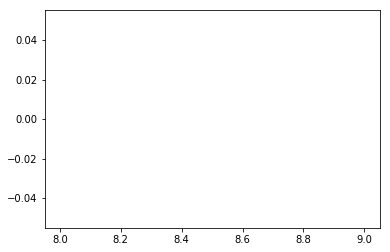

In [96]:
hist,bins = np.histogram(results,bins=50)
plt.hist(hist, bins) 